In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns
from pylab import rcParams
%matplotlib inline
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc


In [197]:
train = pd.read_csv('/Users/robertoaltran/Documents/2:2023/machinelearning/train.csv')
sample_submission = pd.read_csv('/Users/robertoaltran/Documents/2:2023/machinelearning/submission.csv')
test = pd.read_csv('/Users/robertoaltran/Documents/2:2023/machinelearning/test.csv')
print(train.dtypes)

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object


### Task 1

In [3]:
train['EJ'].head()

0    B
1    A
2    B
3    B
4    B
Name: EJ, dtype: object

In [4]:
mapping = {'A': 1, 'B': -1}
train['EJ'] = train['EJ'].replace(mapping) #dando novo valor para EJ
train['EJ'] = train['EJ'].astype(float) #transformando este valor em float
train['Class'] = train['Class'].astype(float) #transformando este valor em float
train["Class"].replace(0, -1, inplace=True)

Loading the CSV file and examining its content, a categorical variable was identified based on the instructions provided on the Kaggle website. The column labeled 'EJ' was selected with the data type 'object'. After closer inspection, it became evident that the values within this column were not in numerical form. So, the  'A' and 'B' were converted to the numerical values 1 and -1.

In [5]:
def split_train_test_data(data_frame, class_column_name, test_size=0.2, random_state=42):
    positive_data = data_frame[data_frame[class_column_name] == 1]
    negative_data = data_frame[data_frame[class_column_name] == -1]
    
    # Embaralhar os dados de cada classe separadamente
    positive_data = positive_data.sample(frac=1, random_state=random_state)
    negative_data = negative_data.sample(frac=1, random_state=random_state)

    # Dividir cada classe em dados de treinamento e teste
    train_positive, test_positive = train_test_split(positive_data, test_size=test_size, random_state=random_state)
    train_negative, test_negative = train_test_split(negative_data, test_size=test_size, random_state=random_state)

    # Combinar os dados de treinamento e teste de ambas as classes
    train_data = pd.concat([train_positive, train_negative])
    test_data = pd.concat([test_positive, test_negative])
    
    return train_data, test_data


In [6]:
train_data, test_data = split_train_test_data(train, 'Class', test_size=0.2, random_state=42)
test_data=test_data.values

In [7]:
label = train_data["Class"].to_numpy()
x = train_data.iloc[:, 1:-1].copy()
x = x.values

The dataset has been divided into training and testing subsets. Additionally, the target label has been extracted.

In [8]:
def initialize_adaboost_parameters(x, T):
    dim = x.shape[1]
    N = x.shape[0]
    
    h = np.zeros([T, 3], dtype=np.float64)
    alpha = np.zeros(T, dtype=np.float64)
    weight = np.ones(N, dtype=np.float64) / N
    err = np.ones(T, dtype=np.float64) * np.inf
    
    return dim, N, h, alpha, weight, err

In [9]:
def calculate_decision_stump_efficient(data, feature, weight, label):

    Tp=np.float64(0); #T+ total sum of positive examples weights
    Tn=np.float64(0) #T- total sum of negative examples weights
    Sp=np.float64(0) #S+ sum of positive weights below the cuurent threshold
    Sn=np.float64(0) #S- sum of negative weights below the current threshold
    error1=np.float64(0)
    error2=np.float64(0)
    min_error=np.float64(2.0) 
    min_thresh=np.float64(0) 
    direction=1
    
    y = np.zeros(N, dtype=np.int64)
    
    #get all positive weights    
    temp  = (label == 1)
    temp = np.int64(temp)
    Tp = np.sum(temp * weight)
    
    #get all negative weights  
    temp  = (label == -1)
    temp = np.int64(temp)
    Tn = np.sum(temp * weight)
    
    #sort feature values
    sorted_labels = data[:, feature].argsort()
    sorted_vector =  data[sorted_labels]

    length = len(sorted_vector)
    for i in range(length):

        #RIGHT DIRECTION THRESHOLD
        #error1 is the sum of positives up to that point + total negatives minus the sum of negatives so far
        error1 = Sp + (Tn - Sn) 
        if label[sorted_labels[i]] == -1 : 
            Sn = Sn +  weight[sorted_labels[i]]
        else :
            Sp = Sp + weight[sorted_labels[i]]
            
        #LEFT DIRECTION THRESHOLD
        error2 = Sn + (Tp - Sp) 
        
        if(min_error > error1) :
            min_error = error1
            min_thresh = sorted_vector[i, feature]
            direction = 1
        if(min_error > error2) :
            min_error = error2
            min_thresh = sorted_vector[i, feature]
            direction = -1           
    
    return min_thresh, direction, min_error

In [10]:
def calculate_alpha(weighted_error):   
        return 0.5 * np.log( (1.0 - weighted_error) / weighted_error )

In [11]:
def classify_dataset_against_weak_classifier(x, thresh, direction):
    
    classification = np.zeros(len(x))
    for i in range(len(x)):
        if direction == -1:
            if x[i] < thresh: classification[i] = 1
            else : classification[i] = -1
        else:
            if x[i] < thresh: classification[i] = -1
            else : classification[i] = 1    
        
                
    return classification 

In [12]:
def update_weights(weight, alpha, classification, label):
    for i in range(len(weight)):
        weight[i] =  weight[i] * np.exp( -1.0 * alpha * classification[i] * label[i] ) 
    return weight

In [13]:
def normalise_weights(weight):
    weight = weight / np.sum(weight)
    return weight 

In [14]:
def classify_sample(xi, boost_classif, threshold):
    boost_classif = boost_classif.values
    classification_sum = np.float64(0)
    for thresh, feat, sign, alpha in boost_classif:
        ht = np.sign(xi[int(feat)] - thresh) * sign
        classification_sum += alpha * ht 
        
    if classification_sum >= threshold:
        return 1
    
    else:
        return -1


In [15]:
T = 10
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)

Next, the parameters for the Adaboost algorithm are specified. The number of iterations is set to begin with a low value and gradually increase. This approach allows us to assess the impact of the number of iterations on the results.

In [16]:
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)

In [17]:
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )

In [18]:
classifier_df10 = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df10['alpha'] = alpha

As can be observed, the first classifier is extracted. This step allows the algorithm to be applied and assesses its performance in classifying the test subset.

In [23]:
def evaluate_and_store_result(store_result, test_train, model_name, threshold, classifier_df ):
    
    resultmatrix = pd.DataFrame(columns=['prevision', 'last_column'])

    for i in range(len(test_train)):
        classification = classify_sample(test_train[i], classifier_df, threshold)
        last_column_value = test_train[i][-1]
        resultmatrix = resultmatrix.append({'prevision': classification, 'last_column': last_column_value}, ignore_index=True)

    predicted = resultmatrix['prevision']
    true_values = resultmatrix['last_column']
    confusion = confusion_matrix(true_values, predicted)
    print(confusion)
    new_row = {'model': model_name, 'TN': confusion[0, 0], 'FP': confusion[0, 1], 'TP': confusion[1, 1], 'FN': confusion[1, 0]}
    store_result = store_result.append(new_row, ignore_index=True)
    
    return store_result


In [24]:
store_result = pd.DataFrame(columns=['model', 'TN', 'FP', 'TP', 'FN'])
threshold = 0
model_name = "Model 1"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df10)

[[45 57]
 [ 2 20]]


The results for the model with 10 iterations and a threshold of 0 can be seen above on the confusion matrix. True possitive are 20 and the true negative 45.


In [25]:
threshold = 3
model_name = "Model 2"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df10 )
threshold = -1
model_name = "Model 3"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold,classifier_df10 )

[[81 21]
 [13  9]]
[[ 8 94]
 [ 0 22]]


The threshold is adjusted to 3 and -1, while keeping the iteration value unchanged to observe if better results can be achieved. Model 2 appears to perform better. The following code will involve increasing the iteration count and combining it with various threshold values. Finally, I will provide a summary of the best-performing model.

In [39]:
T = 50
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )

In [27]:
classifier_df50 = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df50['alpha'] = alpha

In [28]:
threshold = 0
model_name = "Model 4"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df50)

[[24 78]
 [ 2 20]]


In [29]:
threshold = 5
model_name = "Model 5"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df50)

[[58 44]
 [16  6]]


In [30]:
threshold = -3
model_name = "Model 6"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df50)

[[ 8 94]
 [ 0 22]]


In [31]:
T = 100
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)

In [32]:
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)

In [33]:
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )

In [34]:
classifier_df100 = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df100['alpha'] = alpha

In [35]:
threshold = 0
model_name = "Model 7"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df100)

[[24 78]
 [ 2 20]]


In [36]:
threshold = 5
model_name = "Model 8"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df100)

[[58 44]
 [16  6]]


In [37]:
threshold = -3
model_name = "Model 9"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df100)

[[ 8 94]
 [ 0 22]]


In [38]:
store_result

,model,TN,FP,TP,FN
0,Model 1,45,57,20,2
1,Model 2,81,21,9,13
2,Model 3,8,94,22,0
3,Model 4,24,78,20,2
4,Model 5,58,44,6,16
5,Model 6,8,94,22,0
6,Model 7,24,78,20,2
7,Model 8,58,44,6,16
8,Model 9,8,94,22,0


In [40]:
store_result['Precision'] = store_result['TP'] / (store_result['TP'] + store_result['FP'])

# Find the model with the highest precision
best_model = store_result[store_result['Precision'] == store_result['Precision'].max()]

print(best_model)

     model  TN  FP TP  FN Precision
1  Model 2  81  21  9  13       0.3


As mentioned earlier, in accordance with the precision metric, Model 2 outperformed others in classifying the test subset. The iteration count for this model was 10, and the threshold was set to 3.

In [43]:
def sum_classifier_votes_for_each_sample(dataset, df, classifier_df):
    for i in range(len(dataset)):
        classification_sum = np.float64(0)
        neg_votes = np.float64(0)
        pos_votes = np.float64(0)
        for idx, thresh, feat, sign, alpha in classifier_df.itertuples(): 
            ht = np.sign(dataset[i,int(feat)] - thresh) * sign
            classification_sum += alpha * ht
            if ht < 0:
                neg_votes += alpha * ht
            else:
                pos_votes += alpha * ht
 
        df['sum_alpha'].iloc[i] = classification_sum
        df['pos_votes'].iloc[i] = pos_votes
        df['neg_votes'].iloc[i] = neg_votes
    
    return df

In [44]:
test_set_x_df = pd.DataFrame(test_data)
test_set_x_df = pd.DataFrame(test_data)
test_set_x_df['sum_alpha'] = 0 
test_set_x_df['pos_votes'] = 0 
test_set_x_df['neg_votes'] = 0

In [45]:
sum_classifier_votes_for_each_sample(test_data, test_set_x_df, classifier_df10)

/Users/robertoaltran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,sum_alpha,pos_votes,neg_votes
0,67c8bfe99f1c,0.717864,7137.57341,115.376832,53.302467,8.138688,4.540237,0.025578,11.211258,119.908222,...,19.943488,174.626095,142.913889,24.78186,47.522844,0.092272,1.0,3.172464,5.389877,-2.217413
1,bbb1066a9afd,0.264926,1390.0359,85.200147,11.601362,10.217934,5.660901,0.074907,3.396778,3.113404,...,22.966638,72.611063,4646.471769,23.356717,46.537768,0.06245,1.0,3.172464,5.389877,-2.217413
2,8ba157c016ba,1.546826,5700.64154,85.200147,630.51823,16.70214,6.595525,0.025578,11.457036,34.725348,...,10.37173,72.611063,3840.41574,41.719852,75.870142,0.064367,1.0,1.451167,4.529229,-3.078062
3,49b8f248a42f,0.311929,2294.87753,85.200147,7.166458,8.138688,2.577969,0.030755,8.766082,1.2299,...,12.771646,72.611063,38476.24967,36.290913,15.506588,0.106388,1.0,3.172464,5.389877,-2.217413
4,667b389f278d,0.538398,4889.2833,108.548976,7.002317,8.138688,5.93553,0.07308,8.898424,14.259812,...,15.67387,72.611063,1180.078956,23.676723,9.444384,21.978,1.0,1.535714,4.571502,-3.035788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,ffcca4ded3bb,0.482849,2672.53426,546.66393,112.006102,8.138688,3.198099,0.116928,3.396778,7.948668,...,13.67394,72.611063,6850.484442,45.745974,114.842372,21.978,-1.0,-0.185583,3.710854,-3.896437
120,43365f867d38,0.807597,2174.83464,89.768017,88.546327,17.90826,6.032979,0.236901,13.848645,11.416986,...,23.129423,72.611063,31771.62938,19.196639,49.019748,21.978,-1.0,-0.185583,3.710854,-3.896437
121,948043d08210,0.371751,4074.22488,175.895673,25.200289,8.138688,6.883443,0.025578,10.946574,1.2299,...,9.218282,601.215538,38469.54433,39.379343,93.718536,21.978,-1.0,-0.185583,3.710854,-3.896437
122,508bb5c5cf00,0.260653,1642.84362,85.200147,8.433131,8.138688,3.401856,0.025578,15.049176,1.2299,...,18.752832,72.611063,17089.96158,31.301052,99.430948,21.978,-1.0,-0.185583,3.710854,-3.896437


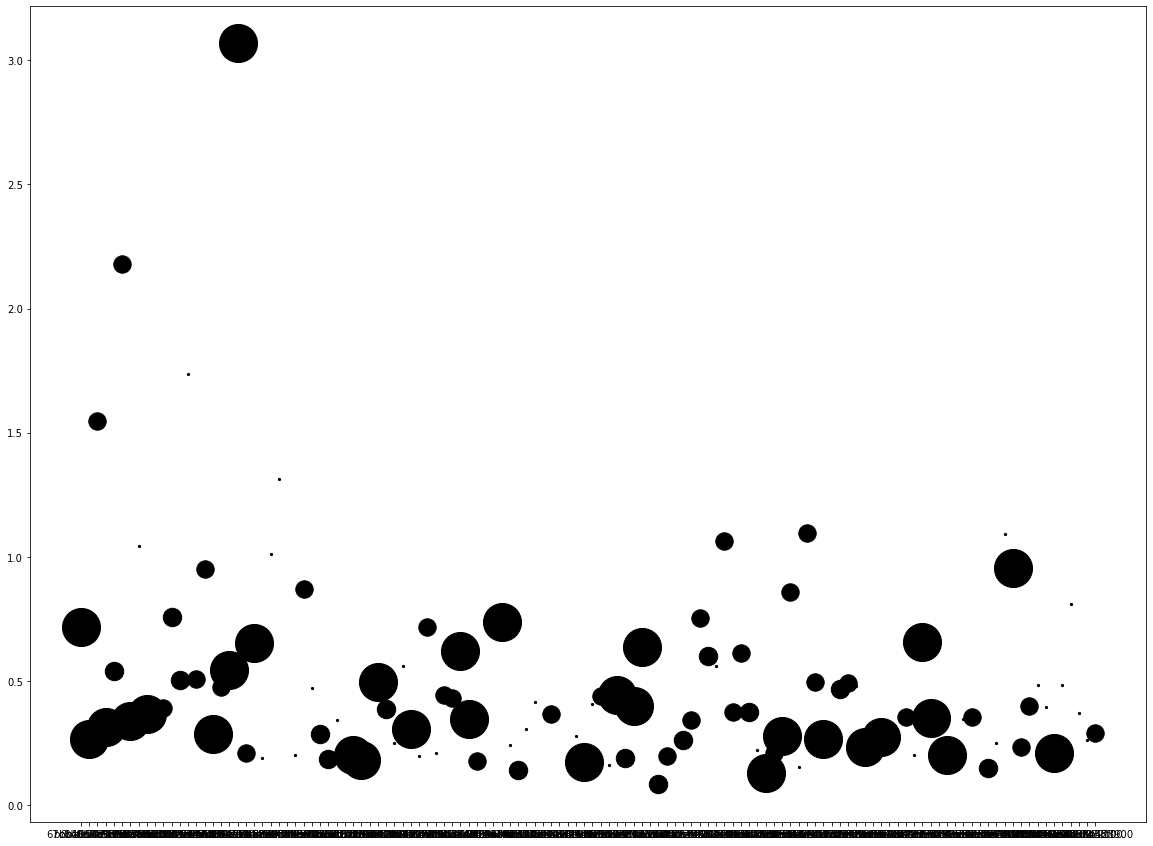

In [46]:
rcParams['figure.figsize'] = 20, 15
for i in range(len(test_data)):
    plt.plot([test_data[i,0]],[test_data[i,1]], 'ko', markersize=(np.abs(test_set_x_df.sum_alpha.iloc[i])*12) )

This plot shows the confidence with which the classifier is applied to each sample. It appears that the classifier is not very confident, as generally, the balls are small.

In [47]:
def margin_calculation(sign, pos, neg, tot_votes):   
    if np.sign(sign) < 0:
        return np.abs(neg) / tot_votes
    else:
        return pos / tot_votes

In [48]:
total_alpha_votes = np.sum(classifier_df10.alpha)


In [55]:
test_set_x_df['total_alpha_votes'] = total_alpha_votes
test_set_x_df['margin'] = test_set_x_df[['sum_alpha','pos_votes','neg_votes','total_alpha_votes']].apply(lambda x: margin_calculation(*x), axis=1)
test_set_x_df.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,sum_alpha,pos_votes,neg_votes,total_alpha_votes,margin
0,67c8bfe99f1c,0.717864,7137.57341,115.376832,53.302467,8.138688,4.540237,0.025578,11.211258,119.908222,...,142.913889,24.78186,47.522844,0.092272,1.0,3.172464,5.389877,-2.217413,7.60729,0.708515
1,bbb1066a9afd,0.264926,1390.0359,85.200147,11.601362,10.217934,5.660901,0.074907,3.396778,3.113404,...,4646.471769,23.356717,46.537768,0.06245,1.0,3.172464,5.389877,-2.217413,7.60729,0.708515
2,8ba157c016ba,1.546826,5700.64154,85.200147,630.51823,16.70214,6.595525,0.025578,11.457036,34.725348,...,3840.41574,41.719852,75.870142,0.064367,1.0,1.451167,4.529229,-3.078062,7.60729,0.595380
3,49b8f248a42f,0.311929,2294.87753,85.200147,7.166458,8.138688,2.577969,0.030755,8.766082,1.2299,...,38476.24967,36.290913,15.506588,0.106388,1.0,3.172464,5.389877,-2.217413,7.60729,0.708515
4,667b389f278d,0.538398,4889.2833,108.548976,7.002317,8.138688,5.93553,0.07308,8.898424,14.259812,...,1180.078956,23.676723,9.444384,21.978,1.0,1.535714,4.571502,-3.035788,7.60729,0.600937


In [56]:
def margin_calculation_for_training_samples(sign, pos, neg, tot_votes ):  
    if np.sign(sign) < 0:
        return np.abs(neg) / tot_votes, -1
    else:
        return pos / tot_votes, 1

In [69]:

training_set_x_df = pd.DataFrame(x)
training_set_x_df['sum_alpha'] = 0 
training_set_x_df['pos_votes'] = 0 
training_set_x_df['neg_votes'] = 0 

training_set_x_df = sum_classifier_votes_for_each_sample(x, training_set_x_df, classifier_df10)

/Users/robertoaltran/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [71]:
training_set_x_df['classification'] = 0
training_set_x_df['margin'] = 0
training_set_x_df['total_alpha_votes'] = total_alpha_votes
result = training_set_x_df[['sum_alpha','pos_votes','neg_votes','total_alpha_votes']].apply(lambda x: margin_calculation_for_training_samples(*x), axis=1)
training_set_x_df['margin'] = result.apply(lambda x: x[0])
training_set_x_df['classification'] = result.apply(lambda x: x[1])
training_set_x_df['true_class_label'] = label
training_set_x_df.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,sum_alpha,pos_votes,neg_votes,classification,margin,total_alpha_votes,true_class_label
0,0.585401,2830.23235,85.200147,14.407244,8.138688,4.305474,0.038976,9.919348,1.229900,5865.79458,...,28.934496,31.175212,0.091696,-1.372956,1.732924,-3.105880,-1,0.408277,7.60729,1.0
1,1.546826,1766.78392,93.874311,23.949101,19.675488,8.136992,0.025578,14.292936,16.023840,3362.14406,...,31.587569,32.520368,21.978000,0.387696,3.567169,-3.179473,1,0.468915,7.60729,1.0
2,0.235015,1608.60062,122.518212,12.041136,8.138688,8.371755,0.025578,6.743140,1.229900,5970.51951,...,25.566991,56.789760,0.069709,-2.954069,0.942368,-3.896437,-1,0.512198,7.60729,1.0
3,0.132463,1777.81186,85.200147,18.591291,8.138688,4.544667,0.115710,9.856328,8.531992,4298.32437,...,29.116825,21.291016,21.978000,-4.204958,0.633846,-4.838804,-1,0.636075,7.60729,1.0
4,0.726410,7720.75106,85.200147,32.595925,8.138688,7.042905,0.025578,11.305788,3.833774,3247.43962,...,29.898235,10.190264,0.594000,0.273480,3.623462,-3.349982,1,0.476314,7.60729,1.0


In [72]:
def sign_of_margin(margin, classification, true_class_label):
 
    return margin * classification * true_class_label
    

In [73]:
training_set_x_df['sign_of_margin'] = training_set_x_df[['margin', 'classification', 'true_class_label']].apply(lambda x: sign_of_margin(*x), axis=1)
training_set_x_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,sum_alpha,pos_votes,neg_votes,classification,margin,total_alpha_votes,true_class_label,sign_of_margin
0,0.585401,2830.23235,85.200147,14.407244,8.138688,4.305474,0.038976,9.919348,1.229900,5865.79458,...,31.175212,0.091696,-1.372956,1.732924,-3.105880,-1,0.408277,7.60729,1.0,-0.408277
1,1.546826,1766.78392,93.874311,23.949101,19.675488,8.136992,0.025578,14.292936,16.023840,3362.14406,...,32.520368,21.978000,0.387696,3.567169,-3.179473,1,0.468915,7.60729,1.0,0.468915
2,0.235015,1608.60062,122.518212,12.041136,8.138688,8.371755,0.025578,6.743140,1.229900,5970.51951,...,56.789760,0.069709,-2.954069,0.942368,-3.896437,-1,0.512198,7.60729,1.0,-0.512198
3,0.132463,1777.81186,85.200147,18.591291,8.138688,4.544667,0.115710,9.856328,8.531992,4298.32437,...,21.291016,21.978000,-4.204958,0.633846,-4.838804,-1,0.636075,7.60729,1.0,-0.636075
4,0.726410,7720.75106,85.200147,32.595925,8.138688,7.042905,0.025578,11.305788,3.833774,3247.43962,...,10.190264,0.594000,0.273480,3.623462,-3.349982,1,0.476314,7.60729,1.0,0.476314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,0.371751,1536.55722,85.200147,11.725242,8.138688,4.216884,0.025578,14.557620,1.229900,4584.40632,...,14.418632,0.022846,-4.838804,0.000000,-4.838804,-1,0.636075,7.60729,-1.0,0.636075
489,2.042494,3209.18378,105.701133,14.837727,8.138688,9.992952,0.025578,13.177482,1.229900,6366.32014,...,21.499348,21.978000,-4.204958,0.633846,-4.838804,-1,0.636075,7.60729,-1.0,0.636075
490,0.363205,1258.32256,85.200147,24.165891,8.138688,5.669760,0.025578,10.448716,1.229900,6999.86322,...,31.712760,0.102600,-4.838804,0.000000,-4.838804,-1,0.636075,7.60729,-1.0,0.636075
491,0.405935,4034.52841,85.200147,18.640843,10.288728,5.040771,0.038671,9.969764,6.655516,9443.14130,...,33.399992,0.099000,-2.704165,2.134640,-4.838804,-1,0.636075,7.60729,-1.0,0.636075


In [74]:
rcParams['figure.figsize'] = 20, 10

margin_10 = training_set_x_df[['sign_of_margin']].copy()


<AxesSubplot:xlabel='sign_of_margin', ylabel='Density'>

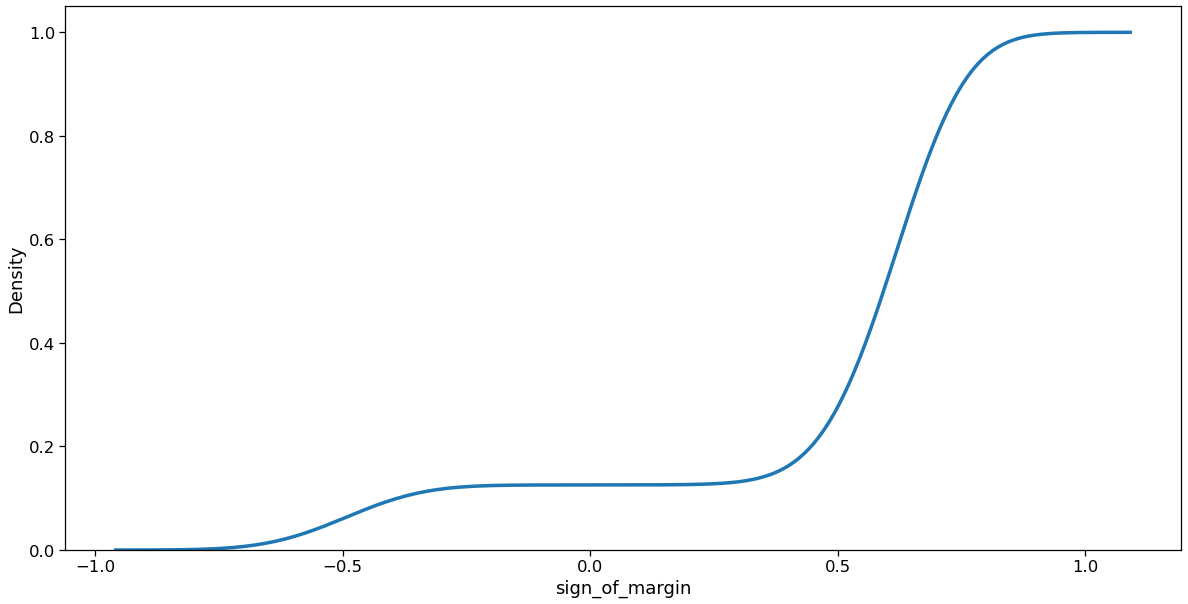

In [75]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5})
rcParams['figure.figsize'] = 20, 10
sns.kdeplot(margin_10.sign_of_margin, cumulative=True, label='classifier size 10')


The graph shows how samples are distributed based on classification margins. Margins indicate how confident the classifier is in its predictions. The dataframe's 'sum_alpha', 'pos_votes', and 'neg_votes' columns reflect these margin-based characteristics. Positive margins indicate confidence in correct predictions, while negative margins show uncertainty. 
No samples have margins between -1 and -0.75 on the x-axis.
A small portion of samples have slightly negative margins between -0.75 and -0.35, with cumulative density around 0.19.
Most samples have margins between -0.35 and 0.35, constituting about 35% of the data.
Many samples have positive margins between 0.35 and 0.75, with cumulative density reaching around 0.75.
Samples with margins above 0.75 are dominant.

## Task2


Now, I will attempt to manipulate the data to see if I can achieve better results by addressing the NaN values in the dataset.

In [76]:
AgingTable =  train
AgingTable.drop('Id', axis=1, inplace=True)

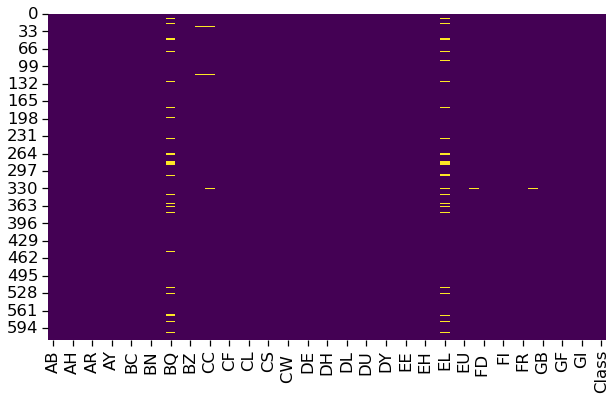

In [77]:
plt.figure(figsize=(10, 6))
sns.heatmap(AgingTable.isnull(), cbar=False, cmap='viridis')
plt.show()

It's possible to observe that two variables have missing values, and the majority of these missing values occur in the same row.

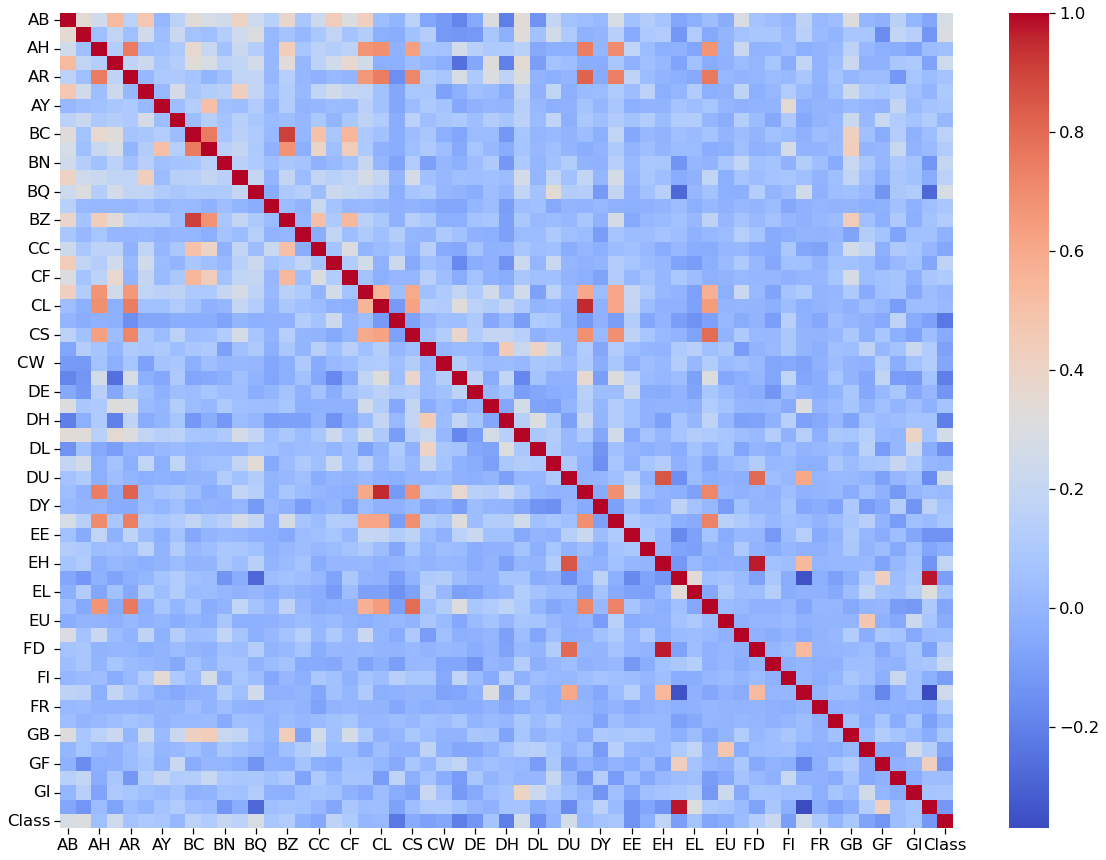

In [78]:
correlation_matrix = AgingTable.corr()
colors = sns.color_palette("coolwarm", as_cmap=True)
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap=colors)
plt.show()

In [82]:
correlation_threshold = 0.7
correlation_list = []

for row in range(len(correlation_matrix)):
    for col in range(row+1, len(correlation_matrix)):
        if abs(correlation_matrix.iloc[row, col]) > correlation_threshold:
            correlation_list.append((correlation_matrix.index[row], correlation_matrix.columns[col]))

# Ordenar a lista com base nas correlações (segundo elemento das tuplas)
sorted_correlation_list = sorted(correlation_list, key=lambda x: abs(correlation_matrix.loc[x[0], x[1]]))

# Imprimir as correlações em ordem crescente
for pair in sorted_correlation_list:
    print(f"Correlação entre {pair[0]} e {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]}")

Correlação entre AH e EB: 0.7051098844404061
Correlação entre DV e EP: 0.7167776407703207
Correlação entre AR e CS: 0.7208532303855877
Correlação entre EB e EP: 0.7293743160463839
Correlação entre AR e EB: 0.7409995605603903
Correlação entre AR e CL: 0.745504296511512
Correlação entre AH e DV: 0.7467150879529467
Correlação entre AH e AR: 0.7497937614501206
Correlação entre BC e BD : 0.753051187522036
Correlação entre AR e EP: 0.7546150039189135
Correlação entre CS e EP: 0.7941579663509495
Correlação entre DU e FD : 0.8059889735701716
Correlação entre AR e DV: 0.8230115789956313
Correlação entre DU e EH: 0.8509567949347095
Correlação entre BC e BZ: 0.9079805920864286
Correlação entre CL e DV: 0.9489914930341183
Correlação entre EH e FD : 0.9711522790899462
Correlação entre EJ e GL: 0.9782126090175094


The correlation matrix and the list above confirm a strong correlation between certain variables, with some of them exceeding a correlation coefficient of 0.9.

In [84]:
from pylab import rcParams
def generate_heatmap(df, column_name):
    # Criando o DataFrame X preenchido com zeros
    X = pd.DataFrame(0, index=df.index, columns=df.columns[1:])
    for col_idx, column in enumerate(df.columns[:]):
        if column == column_name:
            continue
        provisory_df = df[[column, column_name]].copy()
        sorted_df = provisory_df.sort_values(by=column)
        sorted_df['marker'] = 0
        for idx, row in sorted_df.iterrows():
            if pd.isnull(row[column]) and pd.isnull(row[column_name]):
                sorted_df.at[idx, 'marker'] = 3
            elif pd.isnull(row[column]):
                sorted_df.at[idx, 'marker'] = 1
            elif pd.isnull(row[column_name]):
                sorted_df.at[idx, 'marker'] = 2
        X[column] = sorted_df['marker'].values
        del provisory_df
    X = X[df.columns[:]]
    X = X.drop(columns=[column_name])
    colors = ListedColormap(['white', 'green', 'red', 'black'])
    plt.figure(figsize=(15, 15))
    sns.heatmap(X, cbar=False, cmap=colors)
    plt.show()

In [90]:
missing_counts = AgingTable.isnull().sum(axis=1)
total_rows = len(AgingTable)
missing_count_distribution = missing_counts.value_counts().sort_index()
missing_count_distribution['Total'] = total_rows
print("lines with 0 or more missing values:")
print(missing_count_distribution)

lines with 0 or more missing values:
0        548
1         11
2         56
4          2
Total    617
dtype: int64


In [89]:
columns_with_missing_values = AgingTable.columns[AgingTable.isna().any()]
missing_counts = AgingTable[columns_with_missing_values].isna().sum()
missing_percentages = (missing_counts / len(AgingTable)) * 100
missing_info = pd.DataFrame({
    'Quantity': missing_counts,
    '%': missing_percentages
})

print("Missing Values:")
print(missing_info)

Missing Values:
    Quantity         %
BQ        60  9.724473
CB         2  0.324149
CC         3  0.486224
DU         1  0.162075
EL        60  9.724473
FC         1  0.162075
FL         1  0.162075
FS         2  0.324149
GL         1  0.162075


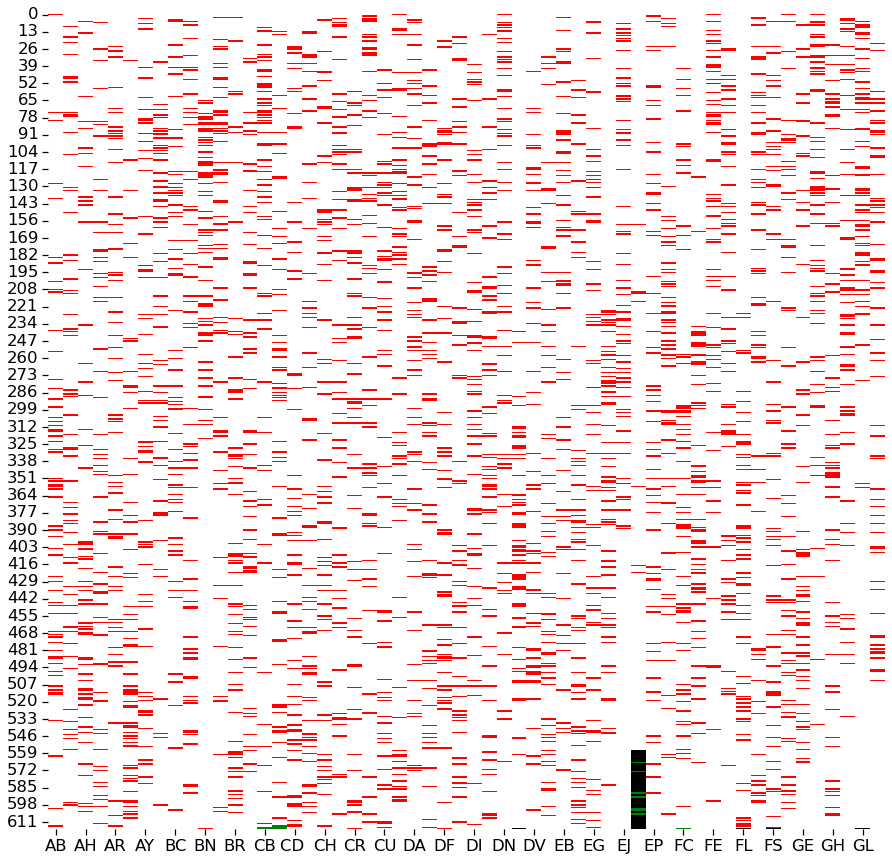

In [85]:
generate_heatmap(AgingTable, 'BQ')

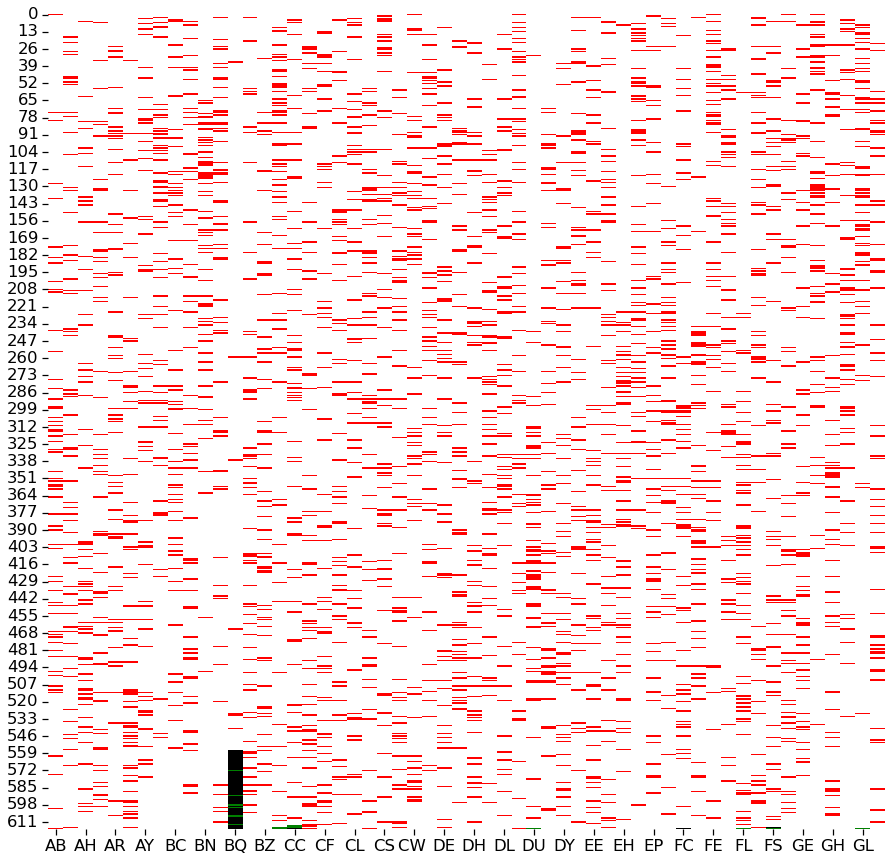

In [86]:
generate_heatmap(AgingTable, 'EL')


The variables BQ and EJ exhibit 60 missing values, accounting for approximately 10% of the dataframe. Given the identical count, it's crucial to investigate whether these missing values follow any discernible pattern in relation to the other variables. Out of these, 56 missing values are present in the same row for both variables, depicted in black on the plot. However, considering the impact of these missing values on other variables, there doesn't appear to be any significant trend or pattern worth highlighting.

In [91]:
def calculate_correlations(df, target_column):
    correlation_with_target = df.corrwith(df[target_column])
    correlation_df = pd.DataFrame({'Variable': correlation_with_target.index, 'Correlation_with_Target': correlation_with_target.values})
    correlation_df = correlation_df.sort_values(by='Correlation_with_Target', ascending=False)
    return correlation_df

In [94]:
correlation_result = calculate_correlations(AgingTable, 'BQ')
print(correlation_result.head(4))  
print(correlation_result.tail(4)) 

   Variable  Correlation_with_Target
12       BQ                 1.000000
31       DN                 0.344137
1        AF                 0.309300
56    Class                 0.281257
   Variable  Correlation_with_Target
34       DY                -0.112139
52       GF                -0.134377
55       GL                -0.279813
39       EJ                -0.282152


In [95]:
correlation_result = calculate_correlations(AgingTable, 'EL')
print(correlation_result.head(4))  
print(correlation_result.tail(4)) 

   Variable  Correlation_with_Target
40       EL                 1.000000
39       EJ                 0.336702
55       GL                 0.314225
51       GE                 0.186231
   Variable  Correlation_with_Target
25       DA                -0.089641
37       EG                -0.090724
17      CD                 -0.104424
21       CR                -0.135894


When comparing the correlation between the two variables, BQ and EL, it's evident that they lack strong correlations with other variables.

In [149]:
agingtable = AgingTable

In [150]:
import pandas as pd
from sklearn.impute import KNNImputer
n_neighbors = 5
imputer = KNNImputer(n_neighbors=n_neighbors)
data_imputed = imputer.fit_transform(agingtable)
agingtable = pd.DataFrame(data_imputed, columns=agingtable.columns)

In [151]:
data_no_variable = agingtable.drop(['EL', 'BQ'], axis=1)

In [152]:
data_no_vari_correlation = agingtable.drop(['EJ', 'EH', 'DV', 'BC', 'EL', 'BQ'], axis=1)

In [153]:
data_no_correlation = agingtable.drop(['EJ', 'EH', 'DV', 'BC'], axis=1)#remove the corre

In [154]:
data_no_lin = AgingTable.dropna(subset=['EL', 'BQ'])#subtrai as linhas 
data_imputed = imputer.fit_transform(data_no_lin)
data_no_line = pd.DataFrame(data_imputed, columns=data_no_lin.columns)



The decision was made to address the missing values using the k-nearest neighbors (KNN) technique and create various datasets to evaluate potential improvements. These datasets include:

A dataframe with all variables and columns, but no missing values.
A dataframe without the two variables BQ and EL, which contain the most missing values.
A dataframe without variables exhibiting high correlation (above 0.85).
A dataframe without variables BQ and EL, and also excluding those with high correlation.
A dataframe without the rows containing missing values.
These datasets were prepared to analyze their impact on the model's performance and determine if any of these approaches could yield better results.

In [102]:
train_data, test_data = split_train_test_data(data_no_variable, 'Class', test_size=0.2, random_state=42)
test_data=test_data.values
label = train_data["Class"].to_numpy()
x = train_data.iloc[:, 1:-1].copy()
x = x.values
T = 10
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 10"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 11"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 12"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)


[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [103]:
T = 50
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 13"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 14"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 15"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)


[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [104]:
T = 100
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 16"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 17"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 18"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)


[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [105]:
train_data, test_data = split_train_test_data(data_no_vari_correlation, 'Class', test_size=0.2, random_state=42)
test_data=test_data.values
label = train_data["Class"].to_numpy()
x = train_data.iloc[:, 1:-1].copy()
x = x.values
T = 10
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 19"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 20"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 21"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)





[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [106]:
T = 50
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 22"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 23"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 24"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [107]:
T = 100
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 25"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 26"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 27"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [108]:
train_data, test_data = split_train_test_data(data_no_correlation, 'Class', test_size=0.2, random_state=42)
test_data=test_data.values
label = train_data["Class"].to_numpy()
x = train_data.iloc[:, 1:-1].copy()
x = x.values
T = 10
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 28"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 29"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 30"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [109]:
T = 50
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 31"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 32"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 33"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[15 87]
 [ 1 21]]
[[57 45]
 [16  6]]
[[  0 102]
 [  0  22]]


In [110]:
T = 100
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 34"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 35"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 36"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[15 87]
 [ 1 21]]
[[57 45]
 [16  6]]
[[  0 102]
 [  0  22]]


In [111]:
train_data, test_data = split_train_test_data(data_no_line, 'Class', test_size=0.2, random_state=42)
test_data=test_data.values
label = train_data["Class"].to_numpy()
x = train_data.iloc[:, 1:-1].copy()
x = x.values
T = 38
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 37"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 11
model_name = "Model 38"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 39"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[38 52]
 [ 5 16]]
[[85  5]
 [15  6]]
[[ 0 90]
 [ 0 21]]


In [112]:
T = 50
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 40"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 41"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 42"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[ 0 90]
 [ 0 21]]
[[ 0 90]
 [ 0 21]]
[[ 0 90]
 [ 0 21]]


In [113]:
T = 100
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 43"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 44"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 45"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[ 0 90]
 [ 0 21]]
[[ 0 90]
 [ 0 21]]
[[ 0 90]
 [ 0 21]]


In [114]:
train_data, test_data = split_train_test_data(agingtable, 'Class', test_size=0.2, random_state=42)
test_data=test_data.values
label = train_data["Class"].to_numpy()
x = train_data.iloc[:, 1:-1].copy()
x = x.values
T = 10
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 46"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 47"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 48"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)



[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [115]:
T = 50
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 49"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 50"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 51"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)


[[15 87]
 [ 1 21]]
[[57 45]
 [16  6]]
[[  0 102]
 [  0  22]]


In [116]:
T = 10
dim, N, h, alpha, weight, err = initialize_adaboost_parameters(x, T)
temp_sum = np.zeros(N, dtype=np.float64)
temp = np.zeros(N, dtype=np.float64)
final_label = np.zeros(N, dtype=np.float64)
misshits = np.array([None] * (T+1), dtype=float)
misshits[0] = 1.0
classification_boundaries = []
weight_prev = weight
weighted_error = np.float64(0)
for t in range(T): 
    for feature in range(dim):
        weighted_error = np.float64(0)
        threshold, sign, weighted_error = calculate_decision_stump_efficient(x, feature, weight, label)       
        if weighted_error < err[t] :
            err[t] = weighted_error
            h[t][0] = threshold
            h[t][1] = feature
            h[t][2] = sign
    alpha[t] = calculate_alpha(err[t])
    classification = classify_dataset_against_weak_classifier(x[:, int(h[t][1]) ], h[t][0], h[t][2] )  
    weight = update_weights(weight, alpha[t], classification, label)
    weight = normalise_weights(weight )
classifier_df = pd.DataFrame(h, columns=['threshold','feature','direction'])
classifier_df['alpha'] = alpha
threshold = 0
model_name = "Model 52"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = 5
model_name = "Model 53"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)
threshold = -3
model_name = "Model 54"
store_result = evaluate_and_store_result(store_result, test_data, model_name, threshold, classifier_df)


[[37 65]
 [ 2 20]]
[[102   0]
 [ 22   0]]
[[  0 102]
 [  0  22]]


In [117]:
store_result.drop(['Precision'], axis=1, inplace=True)


In [118]:
store_result['Precision'] = store_result['TP'] / (store_result['TP'] + store_result['FP']).replace(0, pd.NA)

# Create a new DataFrame excluding rows with NA values in 'Precision'
valid_precision_models = store_result.dropna(subset=['Precision'])


# Find the model with the highest precision
best_model = valid_precision_models[valid_precision_models['Precision'] == valid_precision_models['Precision'].max()]
print(best_model)

       model  TN FP TP  FN Precision
37  Model 38  85  5  6  15  0.545455


One of the dataframes performed better, specifically the dataset without the missing rows. In this case, the chosen iteration was 38, and the threshold value was set to 11. This configuration resulted in improved model performance.

![score](score.png)

## Task 3

In [138]:
agingtable = AgingTable

In [139]:
def split_target(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

In [140]:
from sklearn.model_selection import train_test_split

def split_train_test_stratified(X, y, test_size=0.8, random_state=42):
    positive_indices = y[y == 1].index
    negative_indices = y[y == -1].index
    positive_indices = positive_indices.to_numpy()
    negative_indices = negative_indices.to_numpy() 
    np.random.seed(random_state)
    np.random.shuffle(positive_indices)
    np.random.shuffle(negative_indices)

    test_size_positive = int(test_size * len(positive_indices))
    test_size_negative = int(test_size * len(negative_indices))
    
    train_positive_indices, test_positive_indices = positive_indices[test_size_positive:], positive_indices[:test_size_positive]
    train_negative_indices, test_negative_indices = negative_indices[test_size_negative:], negative_indices[:test_size_negative]

    train_indices = np.concatenate((train_positive_indices, train_negative_indices))
    test_indices = np.concatenate((test_positive_indices, test_negative_indices))
    
    X_train, y_train = X.loc[train_indices], y.loc[train_indices]
    X_test, y_test = X.loc[test_indices], y.loc[test_indices]
    
    return X_train, X_test, y_train, y_test


In [141]:
def evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test, random_state=None):
    model = RandomForestClassifier(random_state=random_state)
    param_grid = {
        'n_estimators': [ 100, 150],
        'max_depth': [ 10, 20, 30]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=random_state)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(confusion)
    print("Classification report:")
    print(report)
    print(f"AUC-ROC: {roc_auc}")
    print(f"AUC-PR: {pr_auc}")
    
    return {
        "Accuracy": accuracy,
        "Confusion Matrix": confusion,
        "Classification report": report,
        "The best hyperparameter": best_params
    }




In [155]:
X, y = split_target(agingtable , 'Class')

In [156]:
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)

In [166]:
results = evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test)
print("Final:", results)


Acurácia: 0.9180327868852459
Matriz de Confusão:
[[99  2]
 [ 8 13]]
Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.93      0.98      0.95       101
         1.0       0.87      0.62      0.72        21

    accuracy                           0.92       122
   macro avg       0.90      0.80      0.84       122
weighted avg       0.92      0.92      0.91       122

AUC-ROC: 0.9377652050919377
AUC-PR: 0.8129107391805737
Resultado final: {'Acurácia': 0.9180327868852459, 'Matriz de Confusão': array([[99,  2],
       [ 8, 13]]), 'Relatório de Classificação': '              precision    recall  f1-score   support\n\n        -1.0       0.93      0.98      0.95       101\n         1.0       0.87      0.62      0.72        21\n\n    accuracy                           0.92       122\n   macro avg       0.90      0.80      0.84       122\nweighted avg       0.92      0.92      0.91       122\n', 'Melhores Hiperparâmetros': {'max_depth': 10, 

In [167]:
X, y = split_target(data_no_variable , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
results = evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test)
print("Final:", results)


Acurácia: 0.9426229508196722
Matriz de Confusão:
[[99  2]
 [ 5 16]]
Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.95      0.98      0.97       101
         1.0       0.89      0.76      0.82        21

    accuracy                           0.94       122
   macro avg       0.92      0.87      0.89       122
weighted avg       0.94      0.94      0.94       122

AUC-ROC: 0.9021687883074022
AUC-PR: 0.8250423031656314
Resultado final: {'Acurácia': 0.9426229508196722, 'Matriz de Confusão': array([[99,  2],
       [ 5, 16]]), 'Relatório de Classificação': '              precision    recall  f1-score   support\n\n        -1.0       0.95      0.98      0.97       101\n         1.0       0.89      0.76      0.82        21\n\n    accuracy                           0.94       122\n   macro avg       0.92      0.87      0.89       122\nweighted avg       0.94      0.94      0.94       122\n', 'Melhores Hiperparâmetros': {'max_depth': 30, 

In [171]:
X, y = split_target(data_no_correlation , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
results = evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test)
print("Final:", results)

Acurácia: 0.9262295081967213
Matriz de Confusão:
[[99  2]
 [ 7 14]]
Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.93      0.98      0.96       101
         1.0       0.88      0.67      0.76        21

    accuracy                           0.93       122
   macro avg       0.90      0.82      0.86       122
weighted avg       0.92      0.93      0.92       122

AUC-ROC: 0.9276284771334276
AUC-PR: 0.790855457197841
Resultado final: {'Acurácia': 0.9262295081967213, 'Matriz de Confusão': array([[99,  2],
       [ 7, 14]]), 'Relatório de Classificação': '              precision    recall  f1-score   support\n\n        -1.0       0.93      0.98      0.96       101\n         1.0       0.88      0.67      0.76        21\n\n    accuracy                           0.93       122\n   macro avg       0.90      0.82      0.86       122\nweighted avg       0.92      0.93      0.92       122\n', 'Melhores Hiperparâmetros': {'max_depth': 20, '

In [172]:
X, y = split_target(data_no_vari_correlation , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
results = evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test)
print("Final:", results)

Acurácia: 0.9426229508196722
Matriz de Confusão:
[[99  2]
 [ 5 16]]
Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.95      0.98      0.97       101
         1.0       0.89      0.76      0.82        21

    accuracy                           0.94       122
   macro avg       0.92      0.87      0.89       122
weighted avg       0.94      0.94      0.94       122

AUC-ROC: 0.9123055162659123
AUC-PR: 0.7922697261832916
Resultado final: {'Acurácia': 0.9426229508196722, 'Matriz de Confusão': array([[99,  2],
       [ 5, 16]]), 'Relatório de Classificação': '              precision    recall  f1-score   support\n\n        -1.0       0.95      0.98      0.97       101\n         1.0       0.89      0.76      0.82        21\n\n    accuracy                           0.94       122\n   macro avg       0.92      0.87      0.89       122\nweighted avg       0.94      0.94      0.94       122\n', 'Melhores Hiperparâmetros': {'max_depth': 30, 

In [173]:
X, y = split_target(data_no_line , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
results = evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test)
print("Final:", results)

Acurácia: 0.8715596330275229
Matriz de Confusão:
[[83  6]
 [ 8 12]]
Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.91      0.93      0.92        89
         1.0       0.67      0.60      0.63        20

    accuracy                           0.87       109
   macro avg       0.79      0.77      0.78       109
weighted avg       0.87      0.87      0.87       109

AUC-ROC: 0.9325842696629214
AUC-PR: 0.6993429998698888
Resultado final: {'Acurácia': 0.8715596330275229, 'Matriz de Confusão': array([[83,  6],
       [ 8, 12]]), 'Relatório de Classificação': '              precision    recall  f1-score   support\n\n        -1.0       0.91      0.93      0.92        89\n         1.0       0.67      0.60      0.63        20\n\n    accuracy                           0.87       109\n   macro avg       0.79      0.77      0.78       109\nweighted avg       0.87      0.87      0.87       109\n', 'Melhores Hiperparâmetros': {'max_depth': 10, 

In [168]:
model = RandomForestClassifier(random_state=42)
X, y = split_target(agingtable , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print(feature_importances_df)

   Feature  Importance
32      DU    0.103867
47      FL    0.056052
29      DI    0.046168
25      DA    0.042349
26      DE    0.039412
8       BC    0.037422
21      CR    0.035852
0       AB    0.032209
44     FD     0.030999
55      GL    0.028956
48      FR    0.028127
1       AF    0.028021
38      EH    0.025927
36      EE    0.024701
28      DH    0.024239
12      BQ    0.021539
16      CC    0.021109
45      FE    0.020200
19      CH    0.015981
13      BR    0.015789
30      DL    0.015307
3       AM    0.015260
17     CD     0.015059
46      FI    0.014416
34      DY    0.013848
10      BN    0.013625
9      BD     0.012595
52      GF    0.011793
53      GH    0.011547
22      CS    0.011315
43      FC    0.010594
31      DN    0.010026
27      DF    0.009973
35      EB    0.009817
23      CU    0.009703
42      EU    0.009624
41      EP    0.009300
50      GB    0.009137
11      BP    0.009082
18      CF    0.009008
54      GI    0.008517
5       AX    0.007976
37      EG 

In [169]:
feature_names = [
    "DU", "FL", "DI", "DA", "DE", "BC", "CR", "AB", "FD ", "GL", 
    "FR", "AF", "EH", "EE", "DH", "BQ", "CC", "FE", "CH", "BR",
    "DL", "AM", "CD ", "FI", "DY", "BN", "BD ", "GF", "GH", "CS",
    "FC", "DN", "DV", 'Class'
]
new_dataframe = agingtable[feature_names]


In [170]:
X, y = split_target(new_dataframe , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
results = evaluate_and_tune_random_forest(X_train, X_test, y_train, y_test)
print("Final:", results)

Acurácia: 0.9016393442622951
Matriz de Confusão:
[[97  4]
 [ 8 13]]
Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.92      0.96      0.94       101
         1.0       0.76      0.62      0.68        21

    accuracy                           0.90       122
   macro avg       0.84      0.79      0.81       122
weighted avg       0.90      0.90      0.90       122

AUC-ROC: 0.925035360678925
AUC-PR: 0.8020321361377789
Resultado final: {'Acurácia': 0.9016393442622951, 'Matriz de Confusão': array([[97,  4],
       [ 8, 13]]), 'Relatório de Classificação': '              precision    recall  f1-score   support\n\n        -1.0       0.92      0.96      0.94       101\n         1.0       0.76      0.62      0.68        21\n\n    accuracy                           0.90       122\n   macro avg       0.84      0.79      0.81       122\nweighted avg       0.90      0.90      0.90       122\n', 'Melhores Hiperparâmetros': {'max_depth': 10, '

After experimenting with the Random Forest classification on the previously created dataframes, the one that yielded the best performance was the dataframe excluding high correlation variables along with the variables BQ and EL. This indicates that the selected dataframe, which excluded highly correlated variables and variables BQ and EL, along with the specified hyperparameters, achieved the highest precision, recall, and F1-score for the classification task.
              precision    recall  f1-score   support

        -1.0       0.92      0.96      0.94       101
         1.0       0.76      0.62      0.68        21
       {'max_depth': 10, 'n_estimators': 100}

In [175]:
test.drop(['Id','EJ', 'EH', 'DV', 'BC', 'EL', 'BQ'], axis=1, inplace=True)

In [176]:
test

,AB,AF,AH,AM,AR,AX,AY,AZ,BD,BN,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
def train_random_forest_with_params(X_train, y_train, max_depth, n_estimators, random_state=42):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    return model


In [188]:
X, y = split_target(data_no_vari_correlation , 'Class')
X_train, X_test, y_train, y_test = split_train_test_stratified(X, y, test_size=0.2, random_state=42)
model = train_random_forest_with_params(X_train, y_train,10, 100)

In [189]:
from sklearn.ensemble import RandomForestClassifier
import joblib

In [191]:
test_data = test

# Make predictions using the trained model
predictions = model.predict(test_data)


[-1. -1. -1. -1. -1.]


In [193]:
probabilities = model.predict_proba(test_data)


In [201]:
sample_submission[['class_0', 'class_1']] = probabilities
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.59,0.41
1,010ebe33f668,0.59,0.41
2,02fa521e1838,0.59,0.41
3,040e15f562a2,0.59,0.41
4,046e85c7cc7f,0.59,0.41
